In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf

In [2]:
%%time
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

Wall time: 27.8 s


In [3]:
# priori model test

sess = ed.get_session()
tf.global_variables_initializer().run()

In [4]:
import pickle
with open('cache_dict_float32','rb') as f:
    cache_dict_float32 = pickle.load(f)
    
stage_list = cache_dict_float32['stage_list_float32']
time_length_list = cache_dict_float32['time_length_list']
latent_scen_4_meansd = cache_dict_float32['latent_scen_4_meansd']

stage_list[0].dtype

dtype('float32')

In [5]:
stage = stage_list[0] 
stage.shape # stage 1 obs


(202, 4, 193)

In [6]:
meansd = np.array(latent_scen_4_meansd[0],dtype='float32') # stage 1 
time_length = np.array(time_length_list[0],dtype='float32') # stage 1

meansd.shape,time_length.shape

((5, 5, 2), (4, 2))

In [7]:
period_num = meansd.shape[0] # in stage 1 -> 5
var_num = meansd.shape[1] # always 5
durations_num = time_length.shape[0] # in stage 1 -> 4
assert time_length.shape[0] == period_num - 1
replay_num = stage.shape[0] # obs

period_num,var_num,durations_num,replay_num

(5, 5, 4, 202)

In [8]:
stage_length = stage.shape[2]
time_axis = np.arange(stage_length, dtype='float32')
_time_axis = np.tile(time_axis,(replay_num, durations_num, 1)) # add batch...
_time_axis.shape

(202, 4, 193)

In [9]:
S = 3

_idurations_loc_loc = np.tile(time_length[:,0],(S,1))
_idurations_loc_scale = np.tile(time_length[:,1],(S,1))

_idurations_loc_loc = np.random.normal(loc = _idurations_loc_loc, scale = 3.0).astype('float32')

In [10]:
# Model

# 开始设定S个策略，这里先硬编码为3个，且手动设定其先验分布使其倾向于体现短中长的分类


durations_loc_param = Normal(loc = _idurations_loc_loc, scale = _idurations_loc_scale) # S x d matrix S for 策略数, d for 阶段数-1

# 所有回放从一个logit化的离散分布中抽值作为其选择哪个的标准

loc_weights = Normal(loc=np.zeros(S,dtype='float32'),scale=np.ones(S,dtype='float32'))
loc_index = ed.models.Categorical(logits = loc_weights,sample_shape = replay_num)

durations_loc = tf.gather(durations_loc_param, loc_index) 
durations_scale =  durations_loc / 10.0 # 暂时没想到什么好办法确定这个参数

durations = ed.models.Normal(loc = durations_loc, scale=durations_scale) # 202 * 2 matrix # yep we remove the sample_shape to fit new extent


In [11]:
# MODEL

#durations = ed.models.Normal(loc = [80.0,51.0], scale=[3.0,10.0], sample_shape=replay_num) # 202 * 2 matrix
# what the heck I cause a fatal error anyway
#durations = ed.models.Normal(loc = time_length[:,0], scale=time_length[:,1], sample_shape=replay_num) # 202 * 4 matrix
breaks = tf.cumsum(durations, axis=1) # 202 * 4 matrix
#_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,2)),(1,2,0))  
_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,durations_num)),(1,2,0))  
_mask = tf.where(_time_axis > _breaks, 
                 tf.ones((replay_num, durations_num, stage_length),dtype=tf.int32), 
                 tf.zeros((replay_num, durations_num, stage_length),dtype=tf.int32))
index = tf.reduce_sum(_mask, axis=1)

# 几个参数就不一样了

'''
_shift_mu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
_ctrl_mu  = np.array([stage[:,1,:80].mean(),stage[:,1,80:131].mean(),stage[:,1,131:].mean()],dtype='float32')
_x_mu     = np.array([stage[:,2,:80].mean(),stage[:,2,80:131].mean(),stage[:,2,131:].mean()],dtype='float32')
_move_mu  = np.array([stage[:,3,:80].mean(),stage[:,3,80:131].mean(),stage[:,3,131:].mean()],dtype='float32')
_move_sd  = np.array([stage[:,3,:80].std(), stage[:,3,80:131].std(), stage[:,3,131:].std() ],dtype='float32')
'''
_shift_mu = meansd[:,0,0]
_ctrl_mu  = meansd[:,1,0]
_x_mu     = meansd[:,2,0]
_move_mu  = meansd[:,3,0]
_move_sd  = meansd[:,3,1] / 10


shift_mu = ed.models.Exponential(rate = 1/_shift_mu)
ctrl_mu = ed.models.Exponential(rate = 1/_ctrl_mu)
x_mu = ed.models.Exponential(rate = 1/_x_mu)
move_mu = ed.models.Exponential(rate = 1/_move_mu) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。
move_sd = ed.models.Exponential(rate = 1/_move_sd) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。

def share_params_into_period(var, index):
    var_list = []
    for i in range(replay_num):
        var_list.append(tf.gather(var,index[i]))
    var_along_replay = tf.stack(var_list)
    return var_along_replay

shift_mu_time = share_params_into_period(shift_mu, index)
ctrl_mu_time = share_params_into_period(ctrl_mu, index)
x_mu_time = share_params_into_period(x_mu, index)
move_mu_time = share_params_into_period(move_mu, index)
move_sd_time = share_params_into_period(move_sd, index)

pressing_shift = ed.models.Poisson(rate = shift_mu_time)
pressing_ctrl = ed.models.Poisson(rate = ctrl_mu_time)
pressing_x = ed.models.Poisson(rate = x_mu_time)
move = ed.models.Normal(loc = shift_mu_time, scale = move_sd_time)

move

<ed.RandomVariable 'Normal_11/' shape=(202, 193) dtype=float32>

In [12]:
pressing_shift.eval()

array([[ 10.,   6.,  10., ...,  10.,   6.,  10.],
       [  9.,  16.,   9., ...,  10.,   7.,  11.],
       [  5.,   6.,   6., ...,   8.,  10.,  16.],
       ..., 
       [  6.,  13.,   7., ...,  15.,   6.,   4.],
       [  9.,  13.,   7., ...,   7.,   3.,   9.],
       [  6.,   5.,  12., ...,  12.,  11.,   9.]], dtype=float32)

In [13]:
# Inference
T = 30000

# 原来先对随机参数durations的后验推断改为推断控制durations隐变量的随机参数的后验分布

idurations_loc_param = np.ones([T, S, durations_num],dtype='float32')
idurations_loc_param[0,:,:] = _idurations_loc_loc #_idurations_loc_param
qdurations_loc_param = ed.models.Empirical(tf.Variable(idurations_loc_param))

# 分配向量概率，既然它本身是正态分布，我们也可以把它看成经过自带的softmax变换

iloc_weights = np.zeros([T,S],dtype='float32') # 就以0,0,0权重开始搜索
qloc_weights = ed.models.Empirical(tf.Variable(iloc_weights))


In [14]:
# 神他妈一堆样板代码，不过没精力想怎么重构了
ishift_mu = np.ones([T,period_num],dtype='float32')
ishift_mu[0,:] = _shift_mu
qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,period_num],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

ix_mu = np.ones([T,period_num],dtype='float32')
ix_mu[0,:] = _x_mu
qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

imove_mu = np.ones([T,period_num],dtype='float32')
imove_mu[0,:] = _move_mu
qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

imove_sd = np.ones([T,period_num],dtype='float32')
imove_sd[0,:] = _move_sd
qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


# proposal variable

gdurations_loc_param = Normal(loc = durations_loc_param, scale = np.ones([S,durations_num],dtype='float32')*0.1)
gloc_weights = Normal(loc = loc_weights, scale = np.ones(S,dtype='float32')*0.1)

poi_scale = 0.1 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale]*period_num)
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale]*period_num)
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale]*period_num)
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01]*period_num)
gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale]*period_num)


In [15]:
# proposal variable

#gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))

#gdurations_loc_param = Normal(loc = durations_loc_param, scale = [[0.1,0.1],[0.1,0.1],[0.1,0.1]])
gdurations_loc_param = Normal(loc = durations_loc_param, scale = np.ones([S,durations_num],dtype='float32')*0.1)
#gloc_weights = Normal(loc = loc_weights, scale = [0.1,0.1,0.1])
gloc_weights = Normal(loc = loc_weights, scale = np.ones(S,dtype='float32')*0.1)

poi_scale = 0.1 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差.[rollback]
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale]*period_num)
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale]*period_num)
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale]*period_num)
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01]*period_num)
gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale]*period_num)


尝试不同的推断方法

In [48]:
inference = ed.MetropolisHastings({durations_loc_param: qdurations_loc_param, loc_weights: qloc_weights,
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations_loc_param: gdurations_loc_param, loc_weights: gloc_weights,
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [49]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 500s | Acceptance Rate: 0.198


In [50]:
def diagnose(channel = None, focus = 0):
    channel = focus if channel == None else channel
    plt.plot(qshift_mu.params.eval()[:,channel])
    plt.title('qshift_mu 0')
    plt.show()
    plt.plot(qctrl_mu.params.eval()[:,channel])
    plt.title('qctrl_mu 0')
    plt.show()
    plt.plot(qx_mu.params.eval()[:,channel])
    plt.title('qx_mu 0')
    plt.show()
    plt.plot(qmove_mu.params.eval()[:,channel])
    plt.title('qmove_mu 0')
    plt.show()
    plt.plot(qmove_sd.params.eval()[:,channel])
    plt.title('qmove_sd 0')
    plt.show()


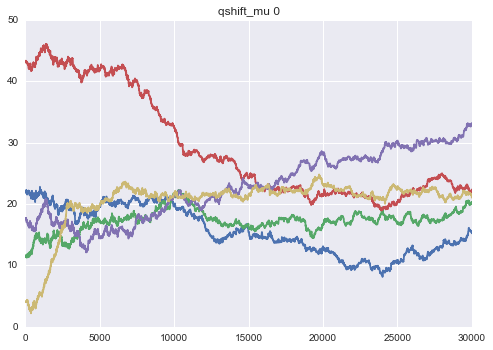

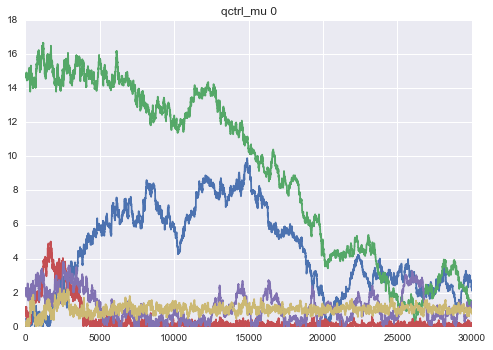

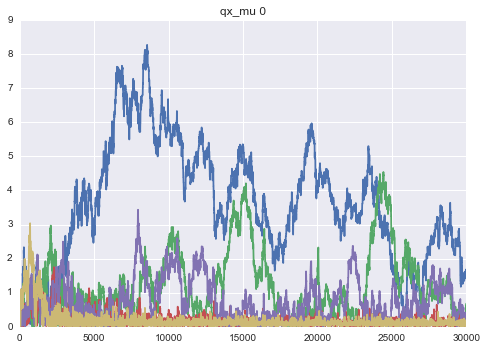

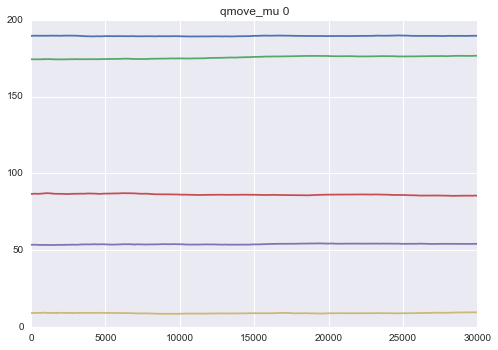

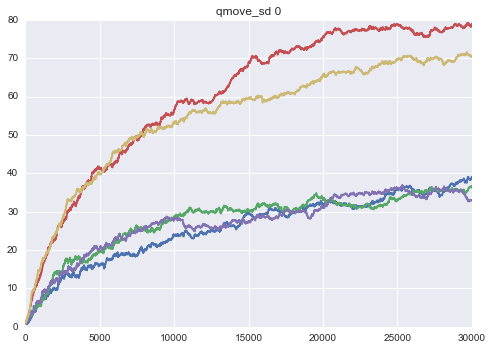

In [51]:
diagnose([0,1,2,3,4])

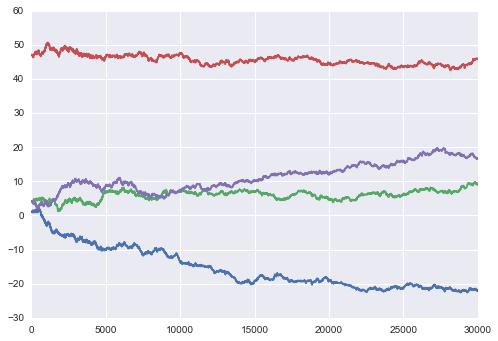

In [52]:
plt.plot(qdurations_loc_param.params.eval()[:,0,:])

In [54]:
def logit(x):
    return np.log(x/(1-x))
def logistic(x):
    return 1/(1+np.exp(-x))
def logistic_to_1(x):
    lx = logistic(x)
    return np.transpose(np.transpose(lx) / np.sum(lx,axis=1))
def softmax(x):
    ex = np.exp(x)
    return np.transpose(np.transpose(ex) / np.sum(ex,axis=1))

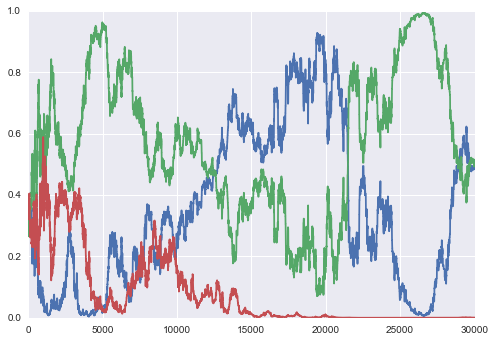

In [55]:
plt.plot(logistic_to_1(qloc_weights.params.eval()))

In [56]:
logistic_to_1(qloc_weights.params.eval())

array([[ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       ..., 
       [ 0.50017917,  0.49896431,  0.00085645],
       [ 0.50017917,  0.49896431,  0.00085645],
       [ 0.50017917,  0.49896431,  0.00085645]], dtype=float32)

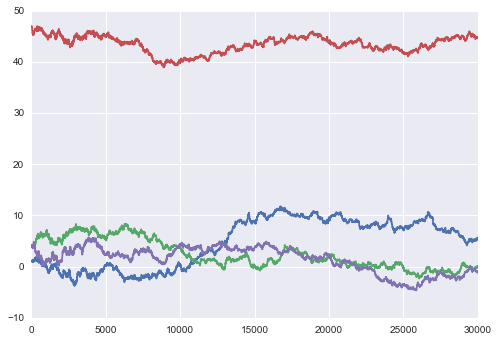

In [57]:
plt.plot(qdurations_loc_param.params.eval()[:,1,:])

In [58]:
qdurations_loc_param.params.eval()[:,1,:]

array([[  1.00000000e+00,   4.00000000e+00,   4.70000000e+01,
          4.00000000e+00],
       [  1.00000000e+00,   4.00000000e+00,   4.70000000e+01,
          4.00000000e+00],
       [  1.00000000e+00,   4.00000000e+00,   4.70000000e+01,
          4.00000000e+00],
       ..., 
       [  5.47746944e+00,   3.15112509e-02,   4.47703209e+01,
         -1.11351323e+00],
       [  5.47746944e+00,   3.15112509e-02,   4.47703209e+01,
         -1.11351323e+00],
       [  5.47746944e+00,   3.15112509e-02,   4.47703209e+01,
         -1.11351323e+00]], dtype=float32)

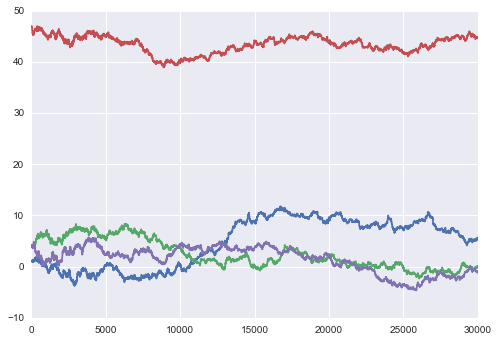

In [59]:
plt.plot(qdurations_loc_param.params.eval()[:,1,:])

In [60]:
qdurations_loc_param.params.eval()[:,1,:]

array([[  1.00000000e+00,   4.00000000e+00,   4.70000000e+01,
          4.00000000e+00],
       [  1.00000000e+00,   4.00000000e+00,   4.70000000e+01,
          4.00000000e+00],
       [  1.00000000e+00,   4.00000000e+00,   4.70000000e+01,
          4.00000000e+00],
       ..., 
       [  5.47746944e+00,   3.15112509e-02,   4.47703209e+01,
         -1.11351323e+00],
       [  5.47746944e+00,   3.15112509e-02,   4.47703209e+01,
         -1.11351323e+00],
       [  5.47746944e+00,   3.15112509e-02,   4.47703209e+01,
         -1.11351323e+00]], dtype=float32)

伪Gibbs采样

In [16]:
from metropolis_hastings_y import MetropolisHastingsY
inference = MetropolisHastingsY({durations_loc_param: qdurations_loc_param, loc_weights: qloc_weights,
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations_loc_param: gdurations_loc_param, loc_weights: gloc_weights,
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [17]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 2606s | Acceptance Rate: 3.353


In [18]:
def diagnose(channel = None, focus = 0):
    channel = focus if channel == None else channel
    plt.plot(qshift_mu.params.eval()[:,channel])
    plt.title('qshift_mu 0')
    plt.show()
    plt.plot(qctrl_mu.params.eval()[:,channel])
    plt.title('qctrl_mu 0')
    plt.show()
    plt.plot(qx_mu.params.eval()[:,channel])
    plt.title('qx_mu 0')
    plt.show()
    plt.plot(qmove_mu.params.eval()[:,channel])
    plt.title('qmove_mu 0')
    plt.show()
    plt.plot(qmove_sd.params.eval()[:,channel])
    plt.title('qmove_sd 0')
    plt.show()


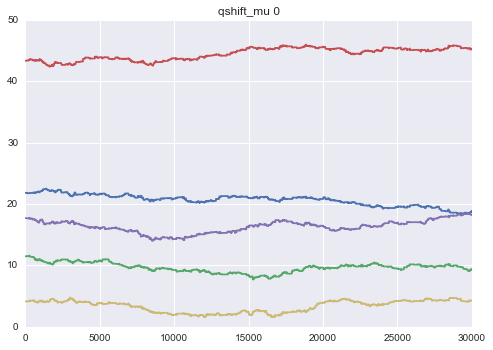

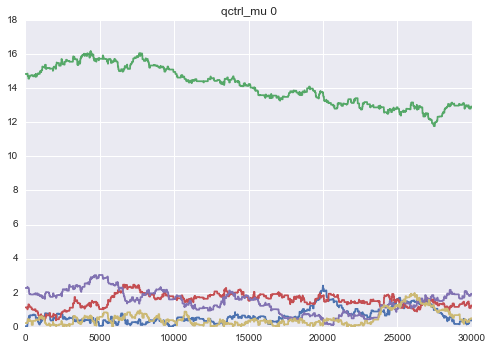

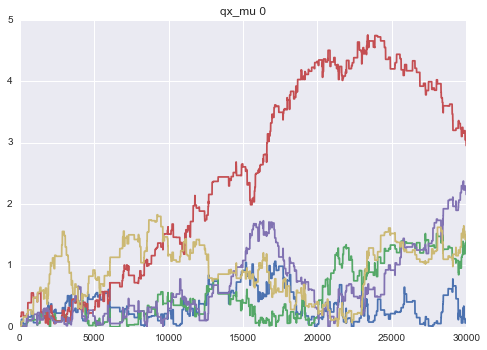

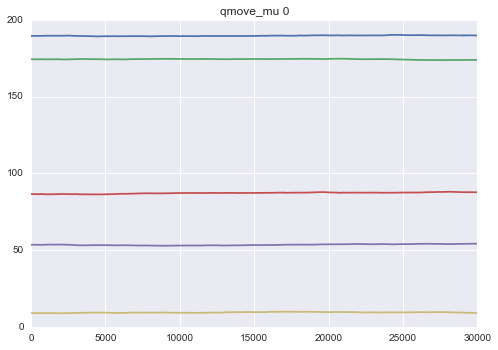

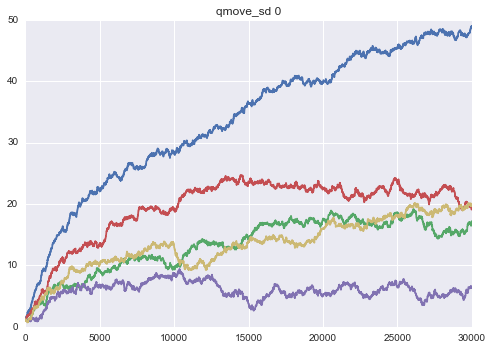

In [19]:
diagnose([0,1,2,3,4])

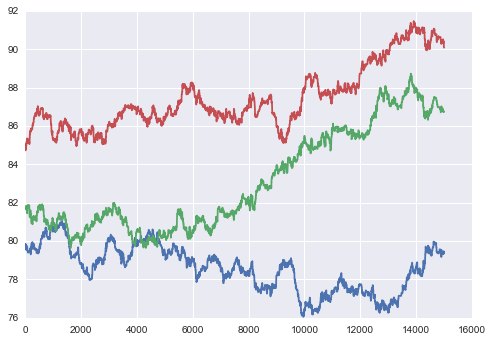

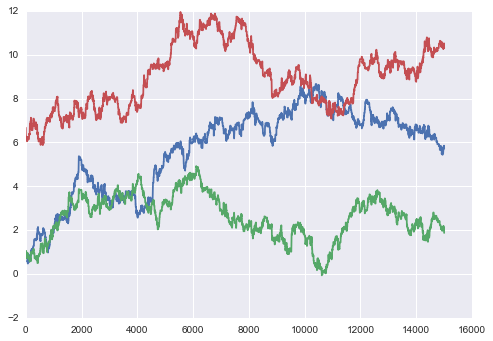

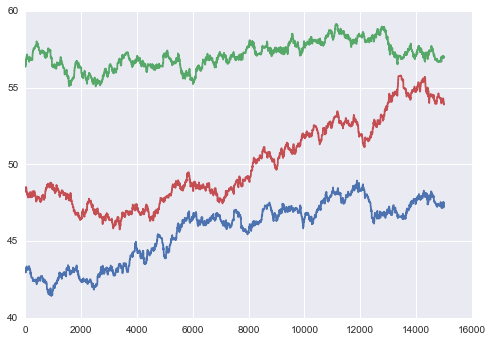

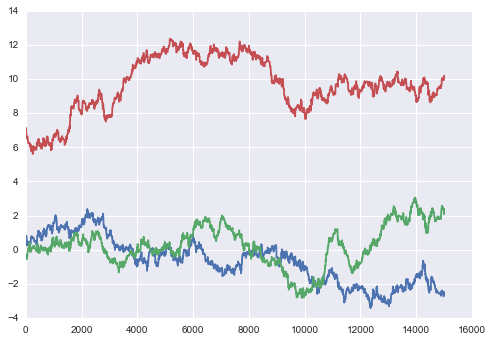

In [21]:
qlp = qdurations_loc_param.params.eval()[15000:,:,:]

plt.plot(qlp[:,:,0])
plt.show()
plt.plot(qlp[:,:,1])
plt.show()
plt.plot(qlp[:,:,2])
plt.show()
plt.plot(qlp[:,:,3])
plt.show()

In [26]:
qloc_weights.params.eval()

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       ..., 
       [ 0.70387042,  2.44234657, -2.68565607],
       [ 0.70387042,  2.44234657, -2.68565607],
       [ 0.70387042,  2.44234657, -2.68565607]], dtype=float32)

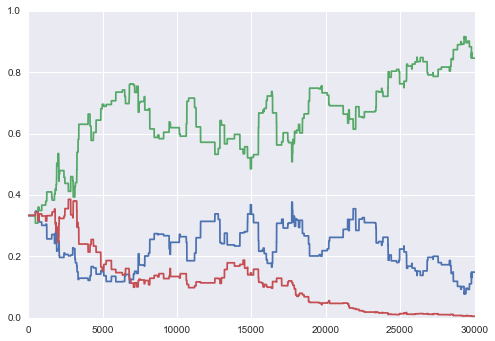

In [24]:
plt.plot(softmax(qloc_weights.params.eval()))

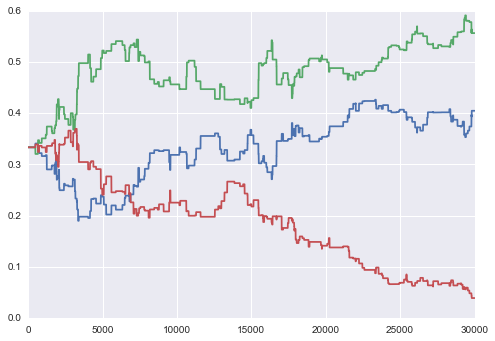

In [25]:
plt.plot(logistic_to_1(qloc_weights.params.eval()))

In [29]:
np.mean(ed.models.Categorical(logits = [0.70,2.44]).sample(1000).eval())

0.84899999999999998

备份报告

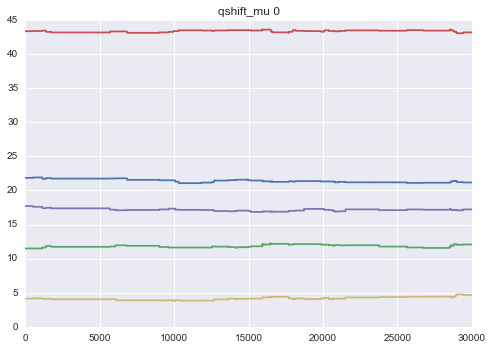

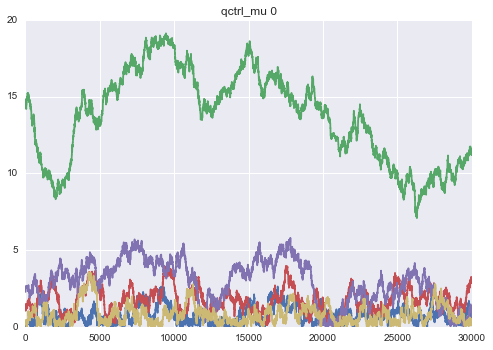

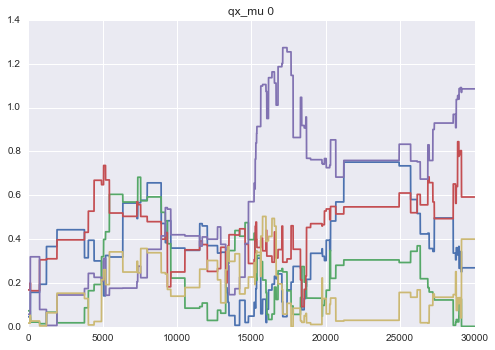

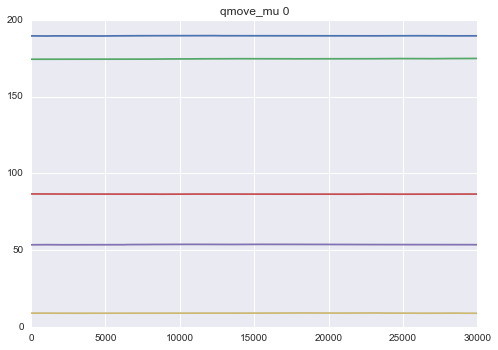

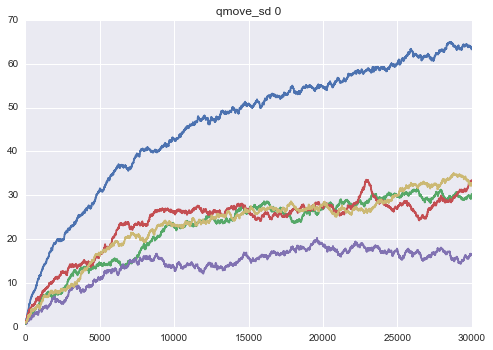

In [36]:
diagnose([0,1,2,3,4])

In [55]:
qlp = qdurations_loc_param.params.eval()[15000:,:,:]

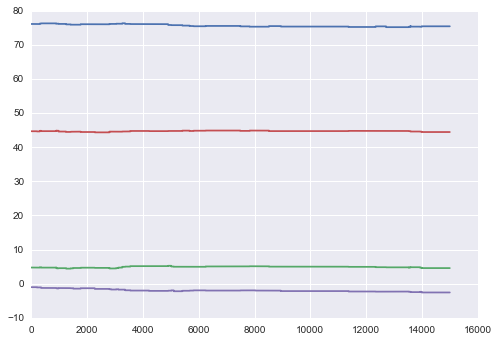

In [56]:
plt.plot(qlp[:,0,:])

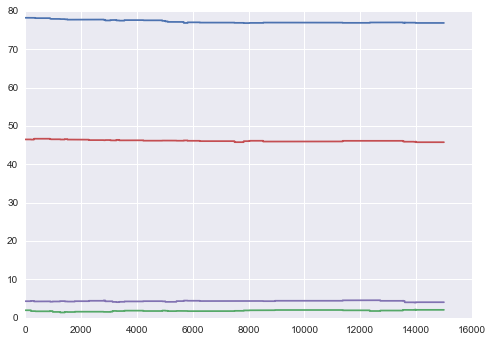

In [57]:
plt.plot(qlp[:,1,:])

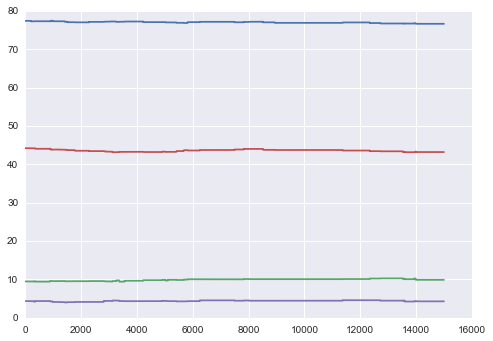

In [58]:
plt.plot(qlp[:,2,:])

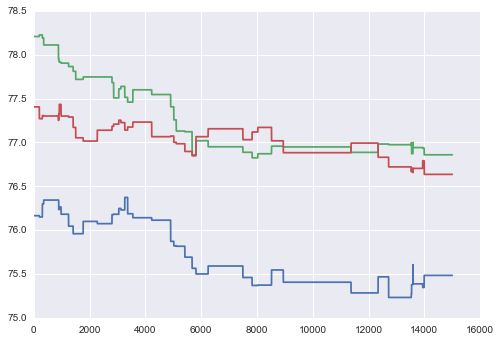

In [59]:
plt.plot(qlp[:,:,0])

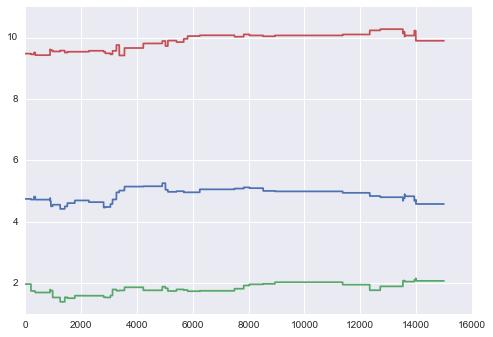

In [60]:
plt.plot(qlp[:,:,1])

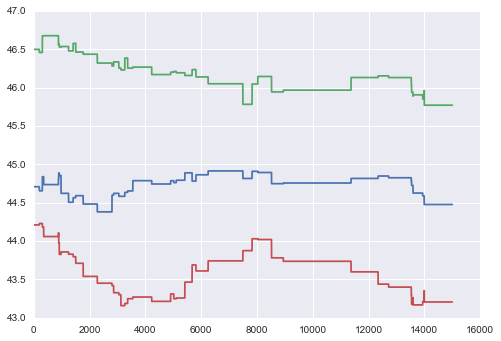

In [61]:
plt.plot(qlp[:,:,2])

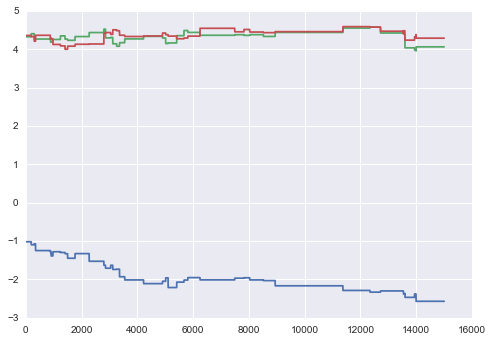

In [62]:
plt.plot(qlp[:,:,3])

In [23]:
def logit(x):
    return np.log(x/(1-x))
def logistic(x):
    return 1/(1+np.exp(-x))
def logistic_to_1(x):
    lx = logistic(x)
    return np.transpose(np.transpose(lx) / np.sum(lx,axis=1))
def softmax(x):
    ex = np.exp(x)
    return np.transpose(np.transpose(ex) / np.sum(ex,axis=1))

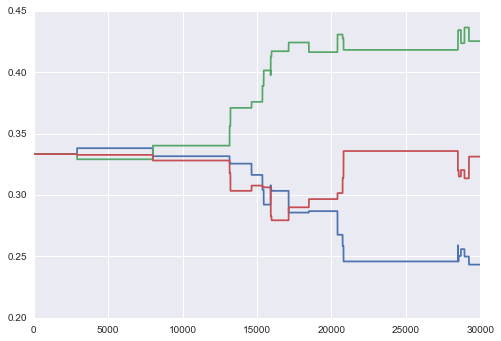

In [39]:
plt.plot(logistic_to_1(qloc_weights.params.eval()))

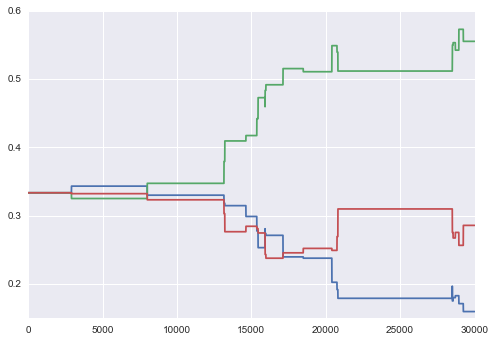

In [40]:
plt.plot(softmax(qloc_weights.params.eval()))